In [1]:
import pandas as pd
import numpy as np
import psycopg2
from analysys_funcs import *
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error


In [47]:
# database connection

conn = psycopg2.connect(host='ep-black-pond-a2ydwdvs.eu-central-1.aws.neon.tech', database='Akademdb', user='Elizar54', password='XUpC1QOnGvA4')
cur = conn.cursor()

In [48]:
# getting data

df = pd.read_sql_query('select * from flats_new', conn)

C:\Users\eliza\AppData\Local\Temp\ipykernel_16288\3829361265.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('select * from flats_new', conn)


In [49]:
# general preproccessing

df['price'] = df['price'].apply(price_corr)
df.drop('id', inplace=True, axis=1)
#df = df.drop_duplicates()

for column in ['total_square', 'living_sq', 'kitchen_sq']:
    df[column] = df[column].apply(square_corr)

df['floor'] = df['floor'].apply(floor_corr)
df['ceil_height'] = df['ceil_height'].apply(lambda x: float(x.replace(',', '.').split()[0]) if x != 'None' else np.nan)
df['entrance'] = df['entrance'].apply(lambda x: int(x) if x != 'None' else np.nan)

df.drop(['warning', 'trash', 'barriers'], inplace=True, axis=1)

df = df.replace('None', np.nan)


df['district'] = df['address'].apply(lambda x: x.split()[4])

df.drop('address', inplace=True, axis=1)

df['warm'].fillna(df['warm'].mode()[0], inplace=True)
df['home_type'].fillna(df['home_type'].mode()[0], inplace=True)
df['metro'] = df['metro'].isna().apply(lambda x: 'Yes' if x == False  else 'No')

In [5]:
df['ceil_height'] = df['ceil_height'].apply(lambda x: x/10 if x > 10 else x)

In [57]:
# separating old and new flats

df_new = df[df['year'].isna() == False]
df_old = df[df['year'].isna() == True]

In [58]:
# working with nan values and feature engineering for old flats

df_old = df_old.dropna(subset=['living_sq', 'kitchen_sq'])
df_old.drop(['decor', 'year', 'floor'], axis=1, inplace=True)

df_old['elevators'] = df_old['elevators'].fillna(df_old['elevators'].mode()[0])
df_old['balcony'] = df_old['balcony'].fillna(df_old['balcony'].mode()[0])
df_old['toilets'] = df_old['toilets'].fillna(df_old['toilets'].mode()[0])
df_old['window_view'] = df_old['window_view'].fillna(df_old['window_view'].mode()[0])
df_old['ceil_height'] = df_old['ceil_height'].fillna(df_old['ceil_height'].mode()[0])
df_old['entrance'] = df_old['entrance'].fillna(df_old['entrance'].mode()[0])
df_old['ceil_height'] = df_old['ceil_height'].apply(lambda x: x if x != 0 else 2.7)

df_old['toilets_united'] = df_old['toilets'].apply(toilet_single)
df_old['toilets_sep'] = df_old['toilets'].apply(toilet_not_sngl)
df_old.drop('toilets', axis=1, inplace=True)

df_old['big_elev'] = df_old['elevators'].apply(big_elevators)
df_old['little_elev'] = df_old['elevators'].apply(lit_elevators)
df_old.drop('elevators', axis=1, inplace=True)

df_old['balcon'] = df_old['balcony'].apply(lambda x: int(x.split()[0]) if 'балкон' in x else 0)
df_old['lodgia'] = df_old['balcony'].apply(lambda x: int(x.split()[0]) if 'лоджия' in x else 0)
df_old.drop('balcony', axis=1, inplace=True)

df_old['warm'] = df_old['warm'].apply(lambda x: 'Центральное' if x == 'Нет информации' else x)

df_old_dummy = pd.get_dummies(df_old, columns=['rented', 'metro', 'window_view', 'home_type', 'warm', 'district'], dtype = 'float64')

In [60]:
df_new = df_new.dropna(subset=['living_sq', 'kitchen_sq'])
df_new.drop(['decor', 'year', 'floor', 'entrance', 'toilets', 'balcony', 'rented', 'window_view'], axis=1, inplace=True)

df_new['elevators'] = df_new['elevators'].fillna(df_new['elevators'].mode()[0])

df_new['ceil_height'] = df_new['ceil_height'].fillna(df_new['ceil_height'].mode()[0])

df_new['ceil_height'] = df_new['ceil_height'].apply(lambda x: x if x != 0 else 2.7)

df_new['big_elev'] = df_new['elevators'].apply(big_elevators)
df_new['little_elev'] = df_new['elevators'].apply(lit_elevators)
df_new.drop('elevators', axis=1, inplace=True)

df_new['warm'] = df_new['warm'].apply(lambda x: 'Центральное' if x == 'Нет информации' else x)
df_new.drop_duplicates()

df_new_dummy = pd.get_dummies(df_new, columns=['home_type', 'warm', 'district', 'metro'], dtype = 'float64')

<Axes: xlabel='Площадь кухни', ylabel='Цена квартиры'>

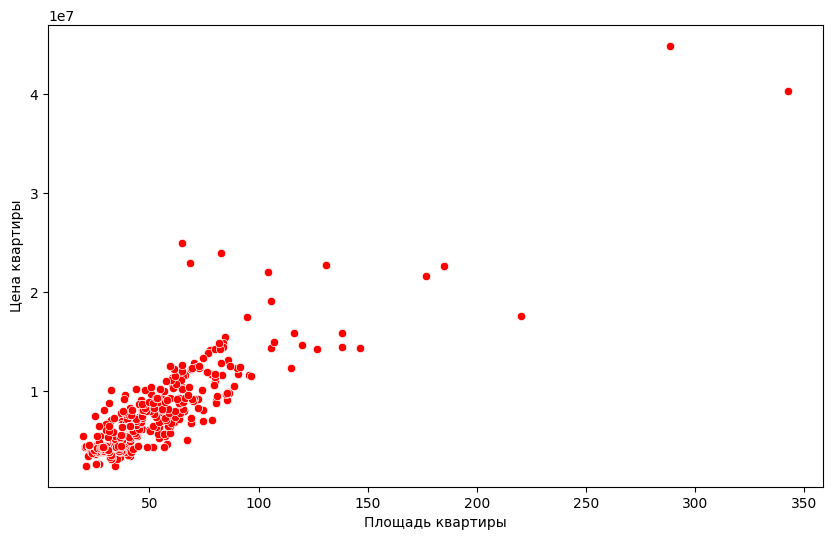

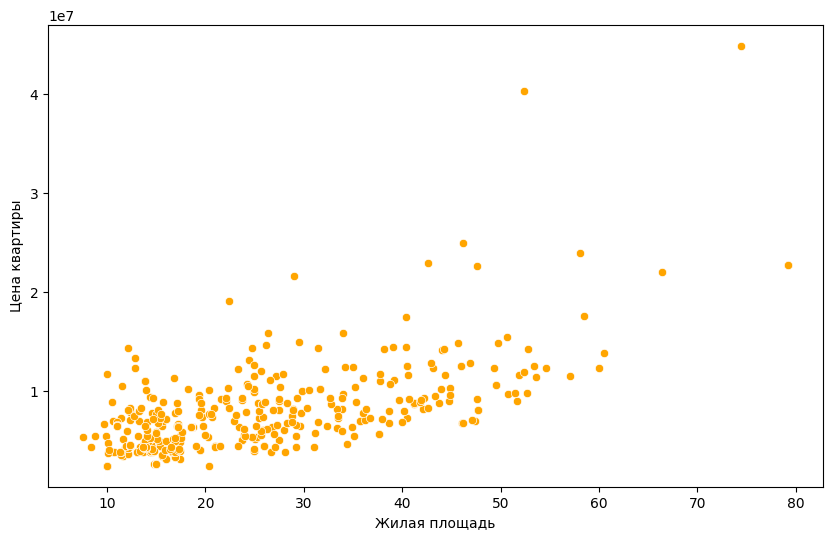

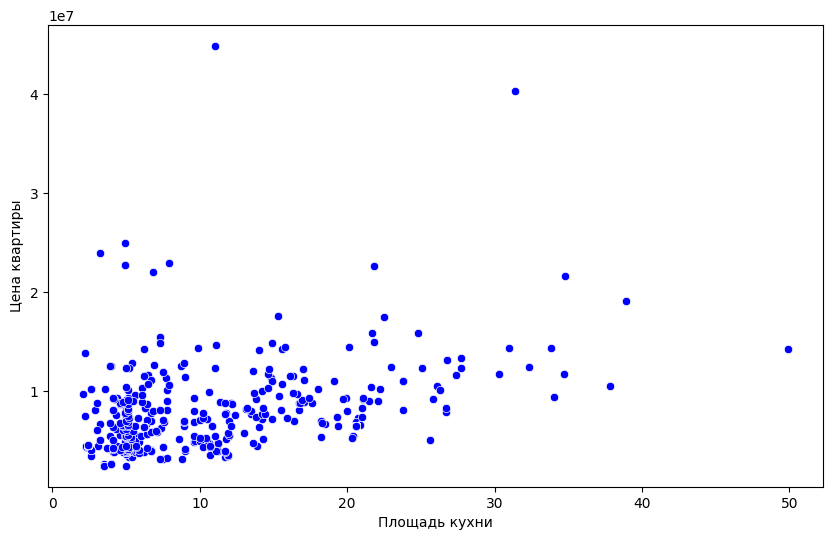

In [61]:
#EDA (new flats)

plt.figure(figsize=(10, 6))

plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_new_dummy['total_square'], y=df_new_dummy['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_new_dummy['living_sq'], y=df_new_dummy['price'], color='orange')

plt.figure(figsize=(10, 6))
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_new_dummy['kitchen_sq'], y=df_new_dummy['price'], color='blue')

<Axes: xlabel='price', ylabel='Density'>

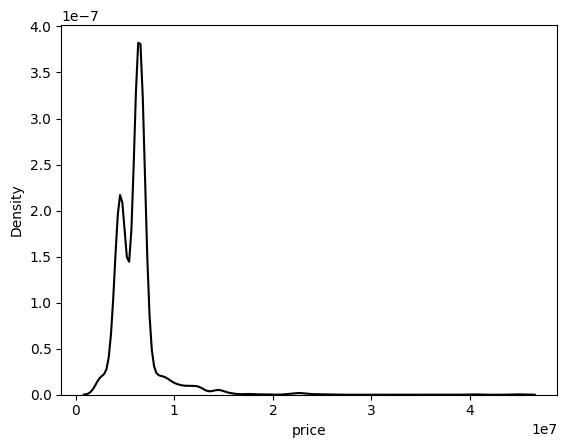

In [66]:
sns.kdeplot(df_new['price'], color='black')

<Axes: xlabel='total_square', ylabel='Density'>

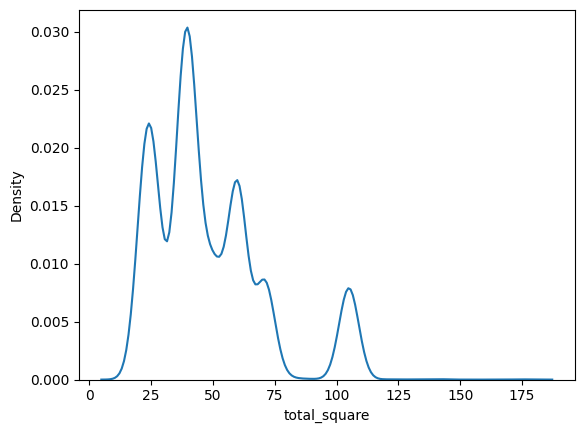

In [67]:
sns.kdeplot(df_old['total_square'])

<Axes: xlabel='Район', ylabel='Количестов квартир'>

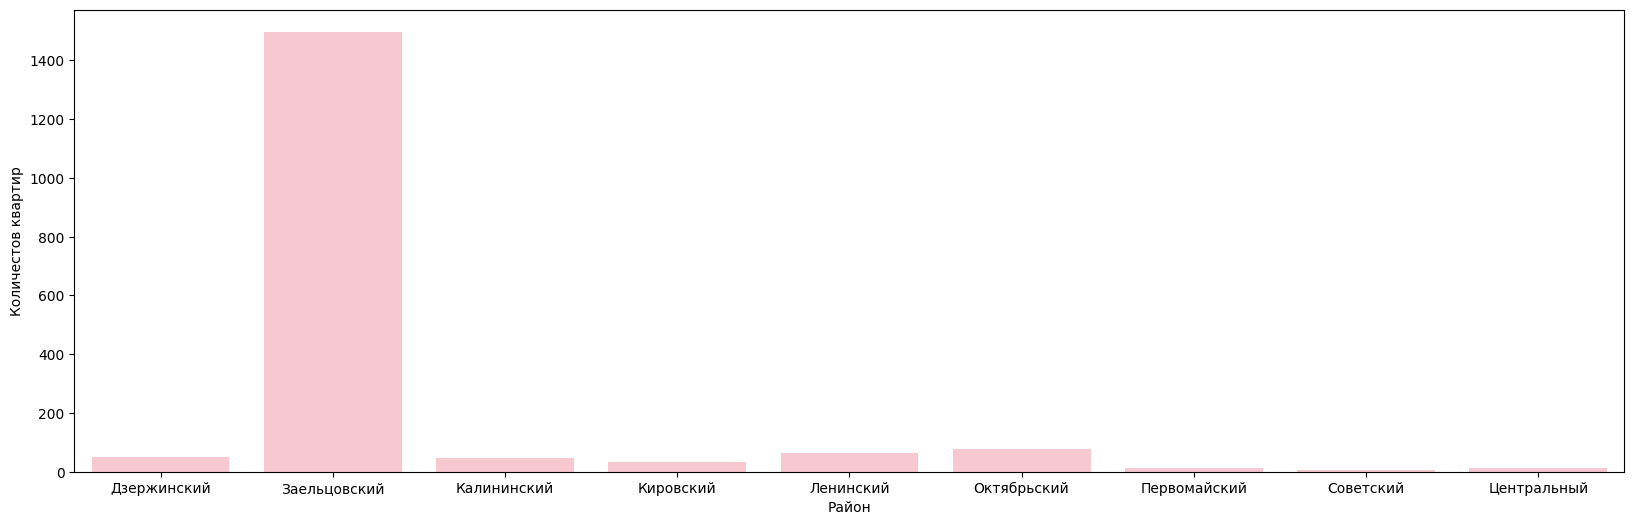

In [69]:
plt.figure(figsize=(20, 6))
plt.ylabel('Количестов квартир')
plt.xlabel('Район')
districts = df_new.groupby('district').count()['price']
sns.barplot(districts, color='pink')

<Axes: xlabel='Площадь кухни', ylabel='Цена квартиры'>

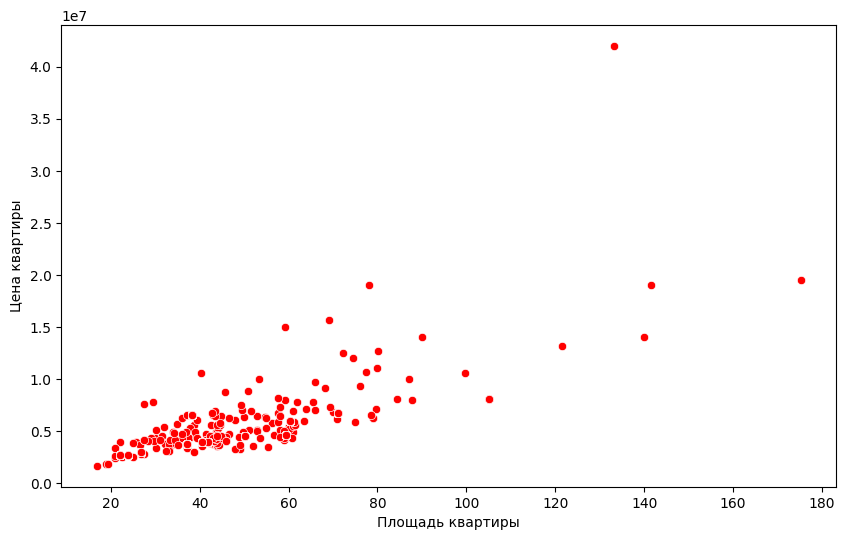

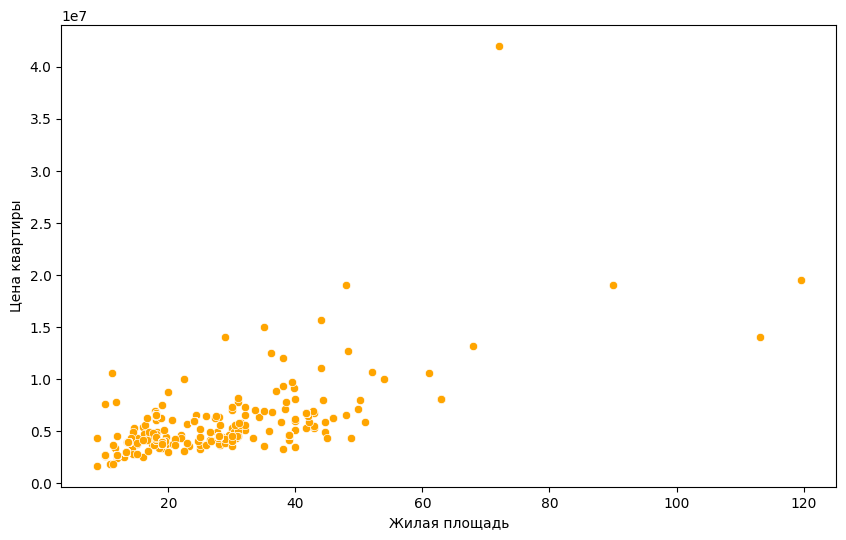

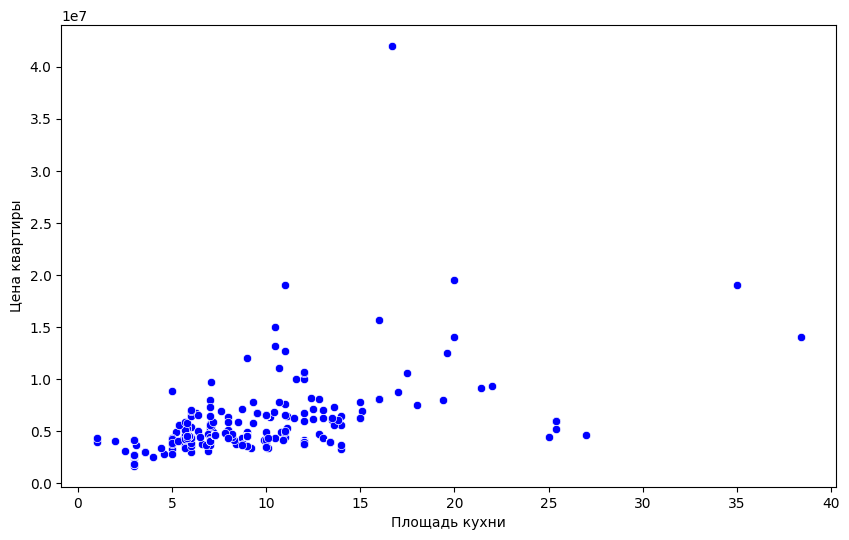

In [9]:
# EDA (old flats)

plt.figure(figsize=(10, 6))

plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old['total_square'], y=df_old['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old['living_sq'], y=df_old['price'], color='orange')

plt.figure(figsize=(10, 6))
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old['kitchen_sq'], y=df_old['price'], color='blue')


<Axes: xlabel='price', ylabel='Density'>

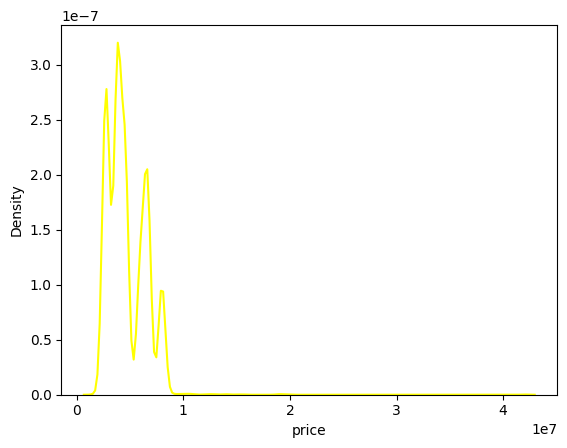

In [10]:
sns.kdeplot(df_old['price'], color='yellow')


<Axes: xlabel='total_square', ylabel='Density'>

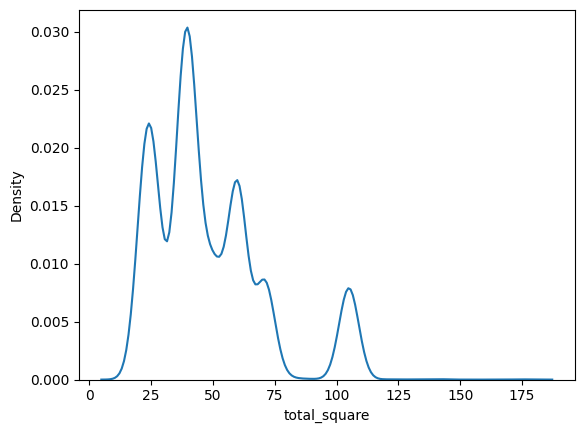

In [11]:
sns.kdeplot(df_old['total_square'])

<Axes: xlabel='Район', ylabel='Количестов квартир'>

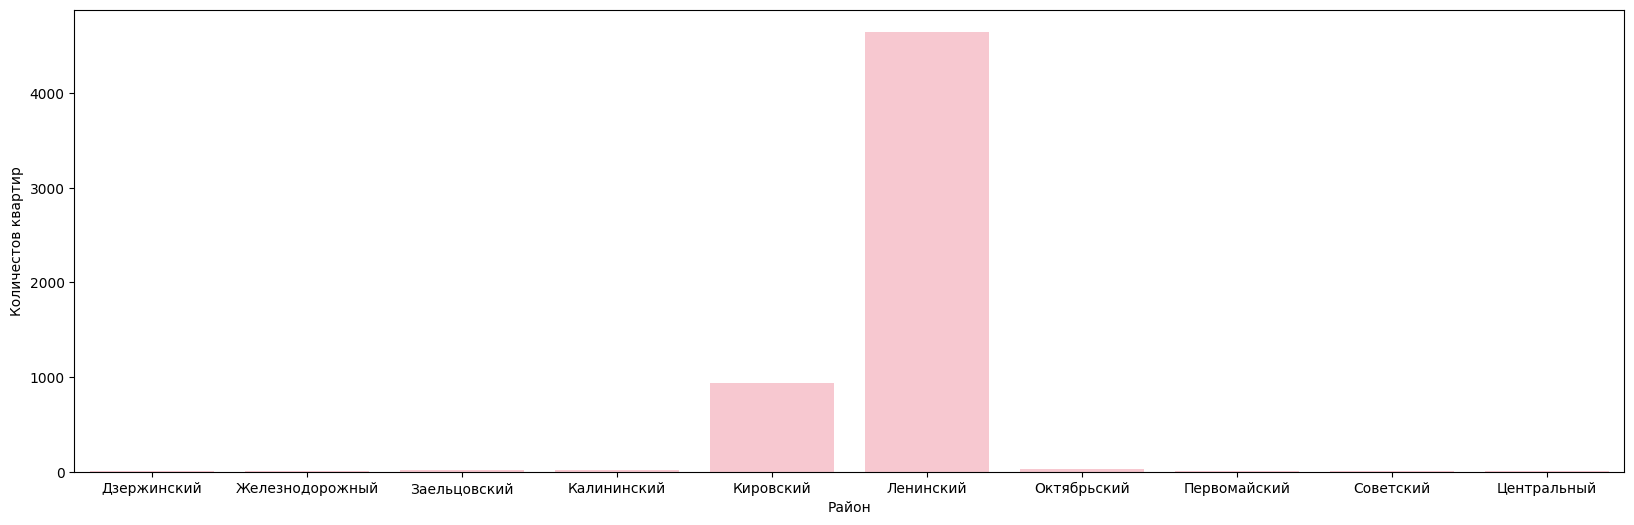

In [12]:
plt.figure(figsize=(20, 6))
plt.ylabel('Количестов квартир')
plt.xlabel('Район')
districts = df_old.groupby('district').count()['rented']
sns.barplot(districts, color='pink')

<Axes: xlabel='Вид из окна', ylabel='Цена квартиры'>

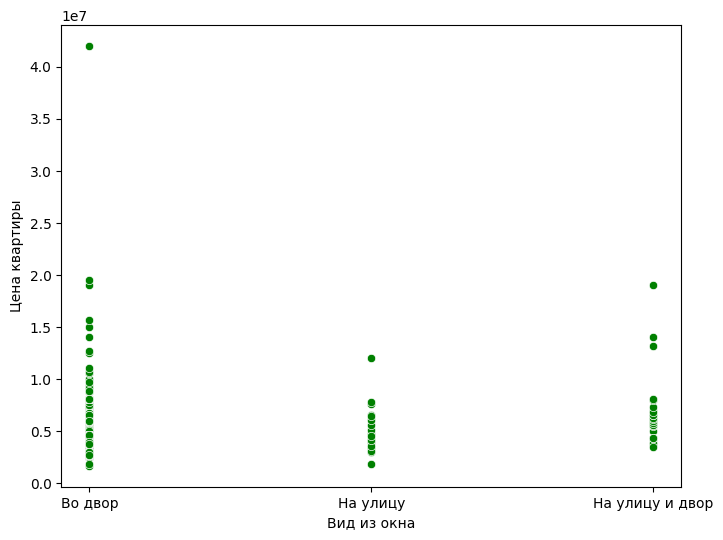

In [13]:
plt.figure(figsize=(8, 6))

plt.xlabel('Вид из окна')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old['window_view'], y=df_old['price'], color='green')

<Axes: xlabel='Высота потолков', ylabel='Цена квартиры'>

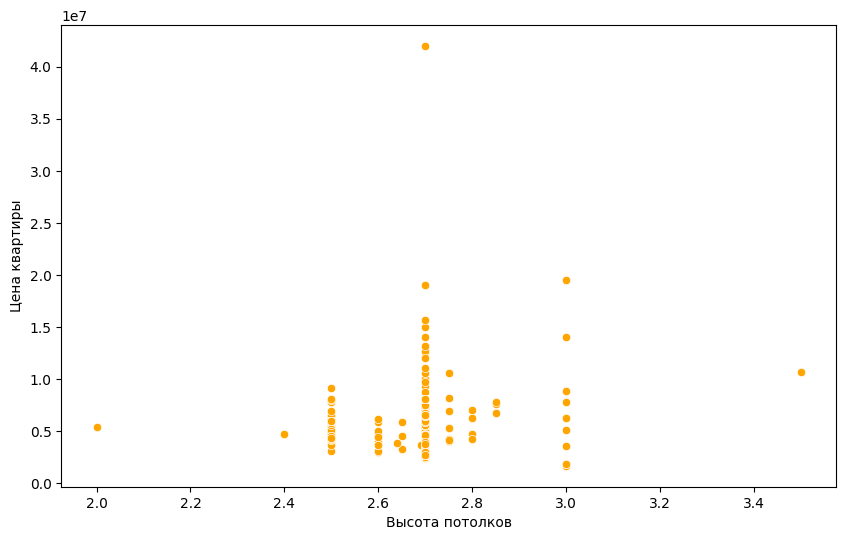

In [14]:
plt.figure(figsize=(10, 6))

plt.xlabel('Высота потолков')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old['ceil_height'], y=df_old['price'], color='orange')

In [15]:
# outliers (old flats)

for column in['total_square']:
    q1 = df_old[column].quantile(0.25)
    q3 = df_old[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df_old_dummy = df_old_dummy[df_old_dummy[column].between(lower_bound, upper_bound)]
    

<Axes: xlabel='total_square', ylabel='Density'>

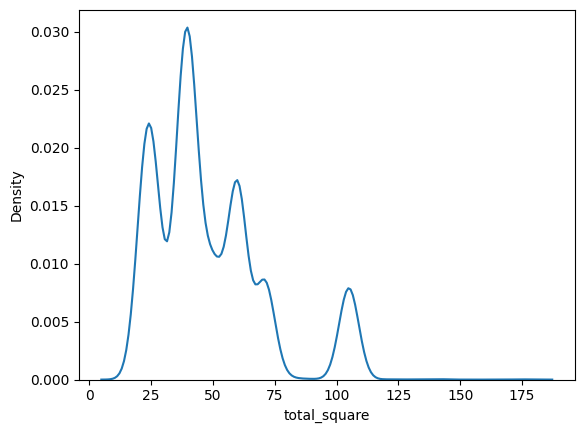

In [16]:
sns.kdeplot(df_old['total_square'])

<Axes: xlabel='Площадь кухни', ylabel='Цена квартиры'>

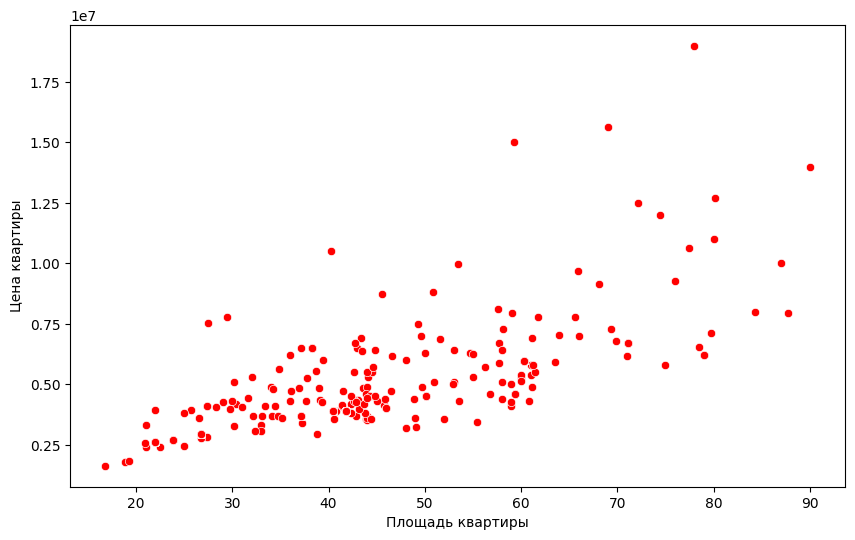

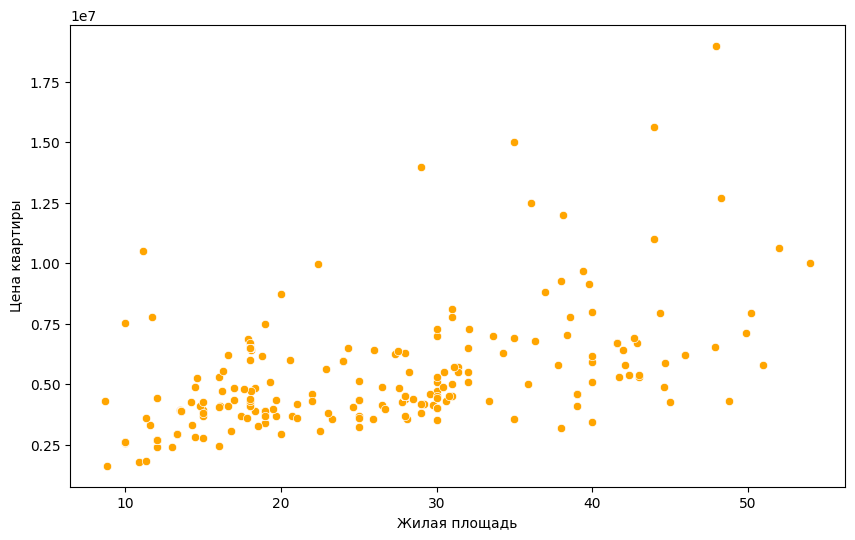

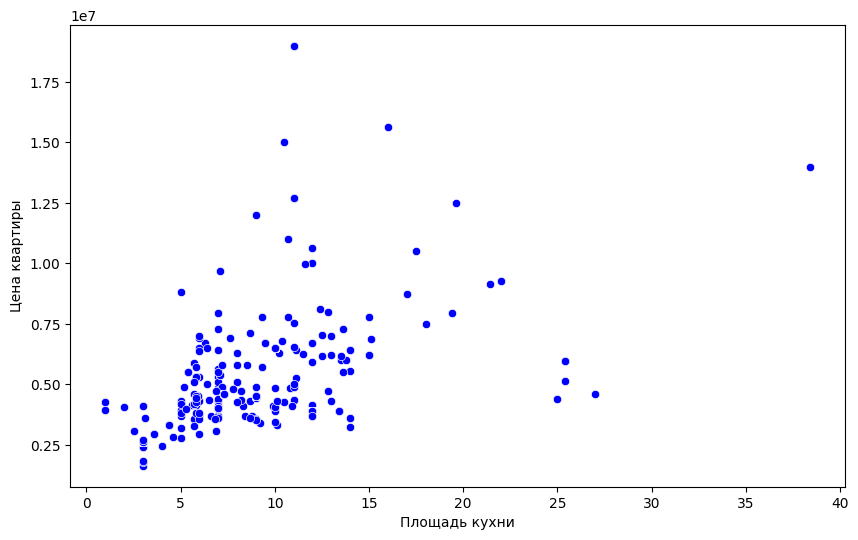

In [17]:
plt.figure(figsize=(10, 6))

plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old_dummy['total_square'], y=df_old_dummy['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old_dummy['living_sq'], y=df_old_dummy['price'], color='orange')

plt.figure(figsize=(10, 6))
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old_dummy['kitchen_sq'], y=df_old_dummy['price'], color='blue')

In [35]:
model_old = CatBoostRegressor()

train, test = train_test_split(df_old_dummy, test_size=0.2, random_state=34)

x = train.drop(['price'], axis=1)
y = train[(train['district_Кировский'] != 1) & (train['district_Ленинский'] != 1)]['price']
model_old.fit(x, y)

Learning rate set to 0.027525
0:	learn: 2776777.9039796	total: 1.73ms	remaining: 1.73s
1:	learn: 2755021.8919056	total: 3.08ms	remaining: 1.54s
2:	learn: 2730007.5402238	total: 4.87ms	remaining: 1.62s
3:	learn: 2703403.8359021	total: 5.89ms	remaining: 1.47s
4:	learn: 2682948.7762021	total: 7.06ms	remaining: 1.4s
5:	learn: 2658236.5386205	total: 7.84ms	remaining: 1.3s
6:	learn: 2634786.7819722	total: 8.65ms	remaining: 1.23s
7:	learn: 2616080.7273152	total: 9.65ms	remaining: 1.2s
8:	learn: 2591115.3981510	total: 10.7ms	remaining: 1.18s
9:	learn: 2568827.6189399	total: 11.8ms	remaining: 1.17s
10:	learn: 2545045.1469907	total: 12.8ms	remaining: 1.15s
11:	learn: 2524665.4311331	total: 13.7ms	remaining: 1.13s
12:	learn: 2505774.4221778	total: 15.2ms	remaining: 1.15s
13:	learn: 2483365.3620207	total: 16.4ms	remaining: 1.16s
14:	learn: 2461901.7259951	total: 17.9ms	remaining: 1.18s
15:	learn: 2440459.7650388	total: 19.7ms	remaining: 1.21s
16:	learn: 2419330.6363507	total: 20.9ms	remaining: 1.2

In [36]:
pred = model_old_kir_len.predict(test[(test['district_Кировский'] == 1) | (test['district_Ленинский'] == 1)].drop('price', axis=1))

In [38]:
mean_absolute_error(test[(test['district_Кировский'] == 1) | (test['district_Ленинский'] == 1)]['price'], pred)

5391.264573144201

Text(0.5, 1.0, 'Feature Importance')

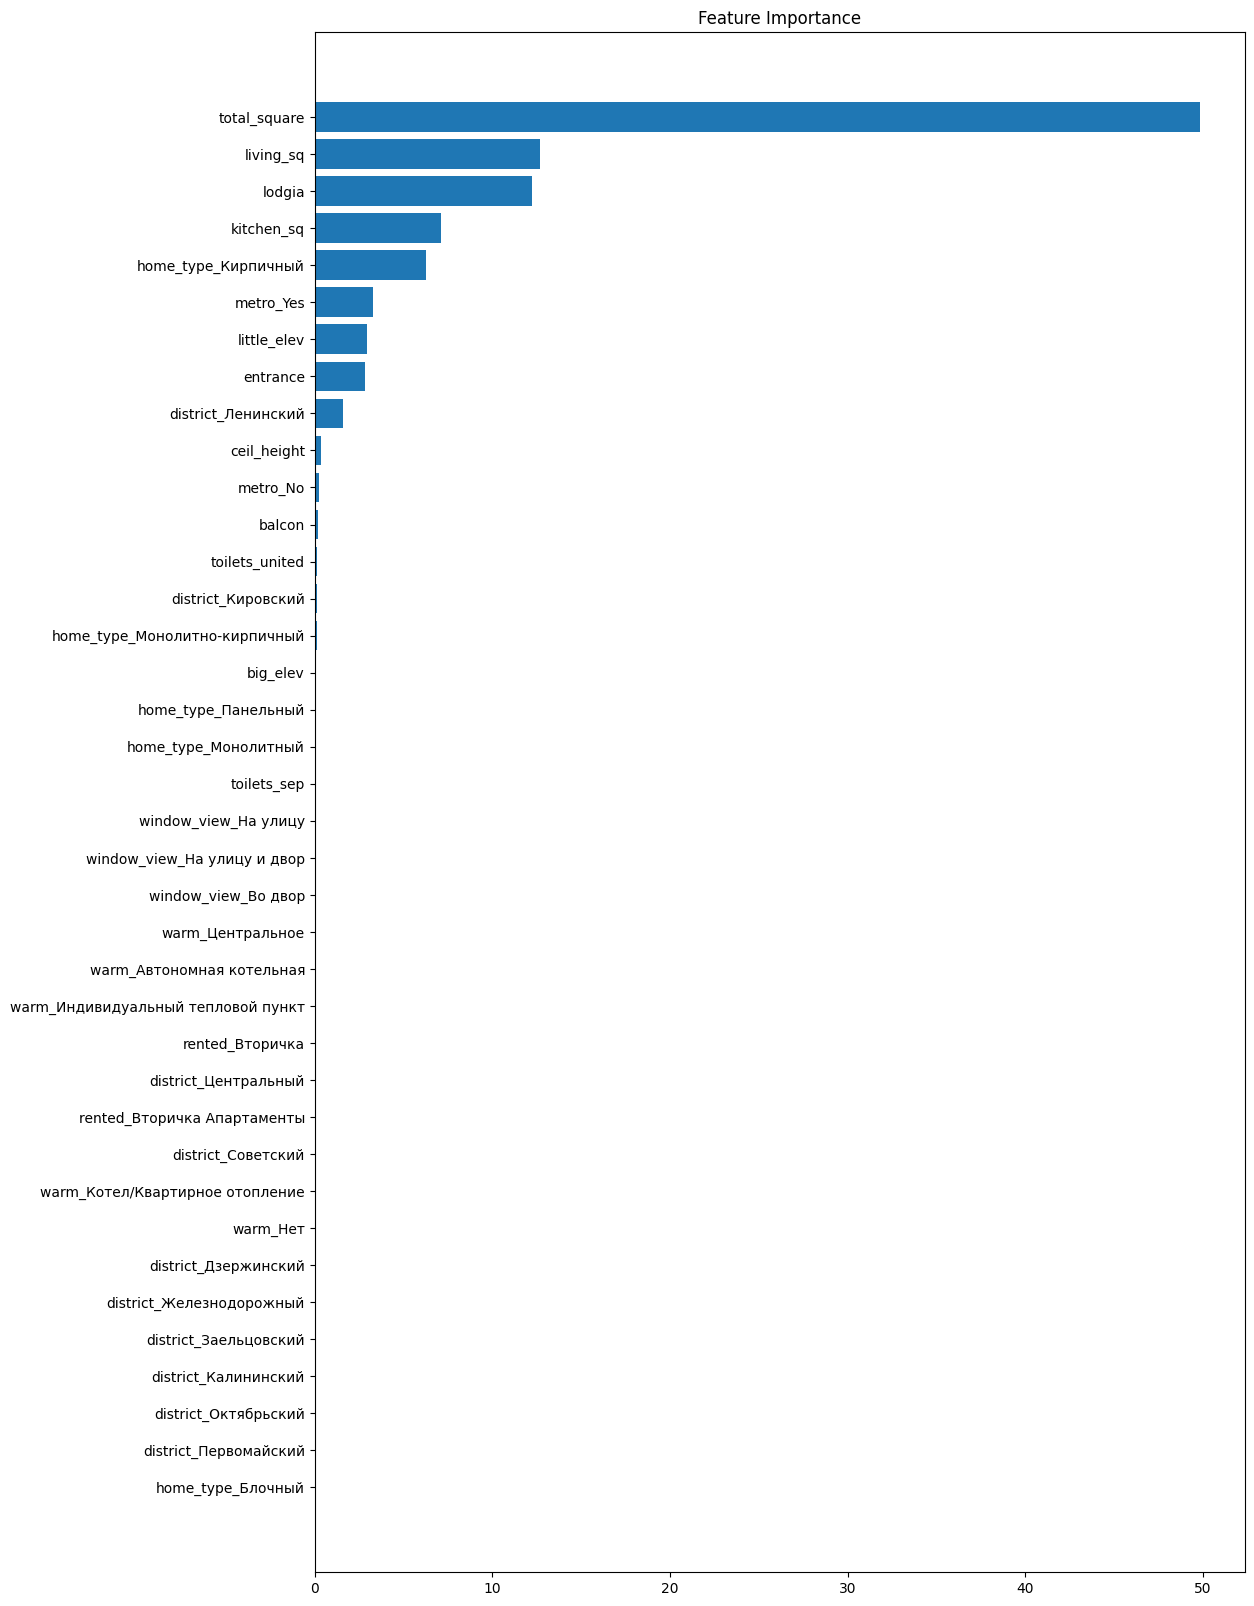

In [39]:
feature_importance = model_old_kir_len.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test.drop('price', axis=1).columns)[sorted_idx])
plt.title('Feature Importance')

In [42]:
pred = model_old_rest.predict(test[(test['district_Кировский'] != 1) & (test['district_Ленинский'] != 1)].drop('price', axis=1))
mean_absolute_error(test[(test['district_Кировский'] != 1) & (test['district_Ленинский'] != 1)]['price'], pred)

1173378.7965417472

In [45]:
train[(train['district_Кировский'] != 1) & (train['district_Ленинский'] != 1)]

,total_square,price,living_sq,kitchen_sq,ceil_height,entrance,toilets_united,toilets_sep,big_elev,little_elev,...,district_Дзержинский,district_Железнодорожный,district_Заельцовский,district_Калининский,district_Кировский,district_Ленинский,district_Октябрьский,district_Первомайский,district_Советский,district_Центральный
153,76.00,9250000,38.0,22.0,2.7,1.0,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1071,80.00,10999000,44.0,10.7,2.7,4.0,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
313,44.10,5300000,30.0,5.8,2.5,4.0,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1289,52.00,3550000,35.0,6.0,2.7,4.0,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
674,63.50,5900000,40.0,12.0,2.7,7.0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,84.30,8000000,40.0,12.8,2.5,8.0,1,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
219,38.70,5549000,16.3,14.0,2.7,2.0,0,1,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,44.50,5500000,31.4,5.4,2.5,4.0,0,1,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,41.45,4700000,16.2,12.8,2.7,1.0,0,1,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
